In [2]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from scipy.interpolate import interp1d
from matplotlib.widgets import Slider, Button

import math
import lightkurve as lk
from astropy.io import fits

In [3]:
search_result = lk.search_tesscut('koi-3678', sector=54)
search_result


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 54,2022,TESScut,475,koi-3678,0.0


In [4]:
tpf = []
for sr in search_result:
    tpf.append(sr.download(cutout_size=(8,8)))

target_mask = [np.array([
    [False, False, False, False, False, False, False, False],
    [False, False, False, False, False, False, False, False],
    [False, False, False, False, False, False, False, False],
    [False, False, False, False,  True,  False, False, False],
    [False, False, False, False,  True,  True, False, False],
    [False, False, False, False, False, False, False, False],
    [False, False, False, False, False, False, False, False],
    [False, False, False, False, False, False, False, False]])]
    

n_target_pixels = []
for a_target_mask in target_mask: 
    n_target_pixels.append(a_target_mask.sum())
    
    
n_target_pixels


[3]

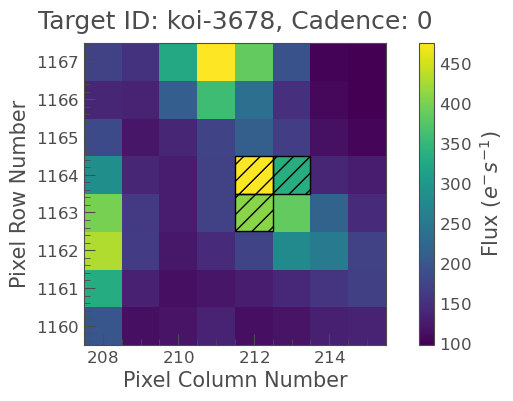

In [5]:
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    a_target_mask = target_mask[ii]
    
    
    a_tpf.plot(aperture_mask=a_target_mask, mask_color='k')
    plt.savefig('koi3678_aperture_smallAperture.pdf')
    plt.show()


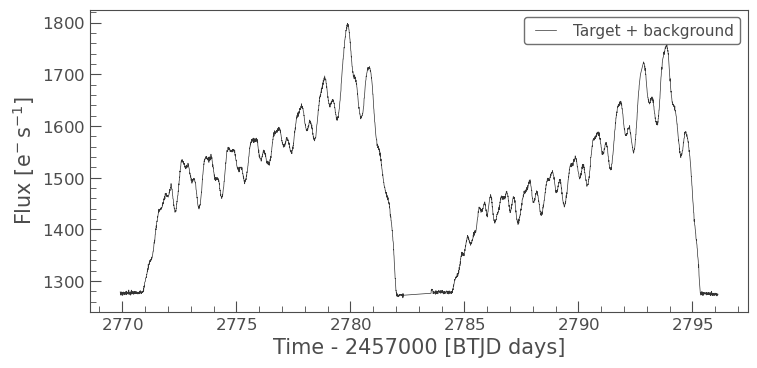

In [6]:
target_lc = []
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    a_target_mask = target_mask[ii]
    
    target_lc.append(a_tpf.to_lightcurve(aperture_mask=a_target_mask))
    
    
    target_lc[ii].plot(label='Target + background');
    


[32]

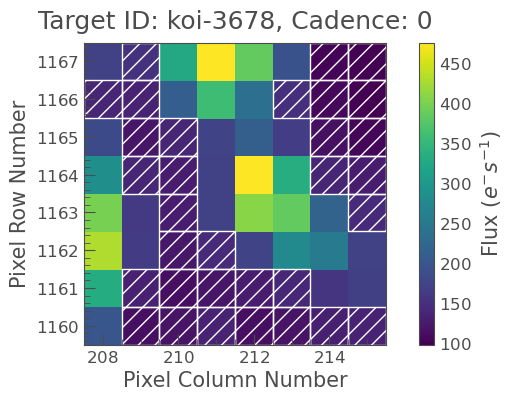

In [7]:
background_mask = []
n_background_pixels = []
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    
    background_mask.append(~a_tpf.create_threshold_mask(threshold=0.0001, reference_pixel=None))
    
    a_tpf.plot(aperture_mask=background_mask[ii], mask_color='w')
    plt.savefig('koi3678_aperture_background_smallAperture.pdf')
    
    n_background_pixels.append(background_mask[ii].sum())

    
    
n_background_pixels



We identified 32 “empty” pixels that could be suitable for estimating the background. The 20x20 cutout has 400 pixels, so these 32 pixels are roughly the pixels with fluxes below the median.

One may object that these ostensibly empty pixels contain background stars, so there is some uncertain zero-point level from imperfect background estimation. That’s true! Background estimation is ultimately a challenge for working with TESS cutouts, especially since background varies in both space and time. Such effects should diminish as your background model approaches reality by modeling or ignoring known background sources and as more instrumental characterization proceeds. The Gaia background sources can be examined using .interact_sky():

In [8]:
background_lc_per_pixel = []
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    a_background_mask = background_mask[ii]
    a_n_background_pixels= n_background_pixels[ii]
    
    
    background_lc_per_pixel.append(
        a_tpf.to_lightcurve(aperture_mask=a_background_mask) / a_n_background_pixels)


The amount of background seen in the target aperture is the background flux per pixel times the number of pixels in the target aperture.



In [9]:
background_estimate_lc = []
background_estimate_lc2 = []
for ii in range(0, len(tpf)):
    a_background_lc_per_pixel = background_lc_per_pixel[ii]
    a_n_target_pixels = n_target_pixels[ii]
    a_n_target_pixels2 = 3

    
    
    background_estimate_lc.append(a_background_lc_per_pixel * a_n_target_pixels)
    background_estimate_lc2.append(a_background_lc_per_pixel * a_n_target_pixels2)


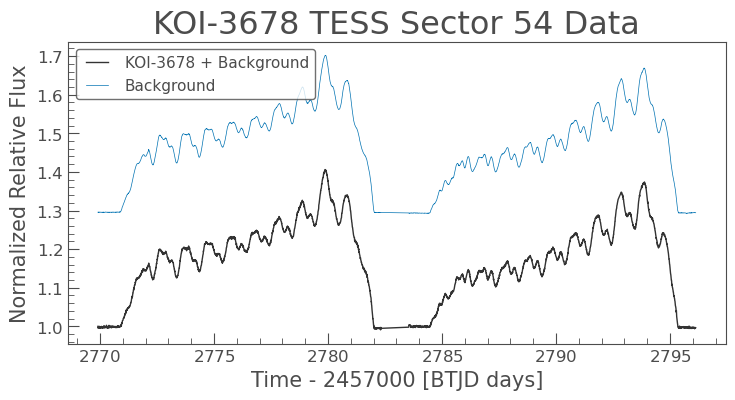

In [10]:
common_normalization = []
for ii in range(0, len(tpf)):
    a_target_lc = target_lc[ii]
    a_background_estimate_lc = background_estimate_lc[ii]
    a_background_lc_per_pixel = background_lc_per_pixel[ii]
    a_n_target_pixels = n_target_pixels[ii]
    
    
    a_common_normalization = np.nanpercentile(a_target_lc.flux, 10)
    common_normalization.append(a_common_normalization)
    
    ax = (a_target_lc / a_common_normalization).plot(normalize=False, label='KOI-3678 + Background', lw=1);
    (a_background_estimate_lc / a_common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized Relative Flux');
    
    
    plt.title('KOI-3678 TESS Sector 54 Data', fontsize=23)
    plt.savefig('koi3678_tess_rawLC_smallAperture.pdf')


In [11]:
epoch = 2456397.578 - 2457000

kepler_epochs = []
for ii in range (0, 50):
    epoch += 160.8845
    kepler_epochs.append(epoch)
    
    
    

epoch = 2456397.578 - 2457000
all_epochs = []
for ii in range (0, 50):
    epoch += 160.8845
    all_epochs.append(epoch)

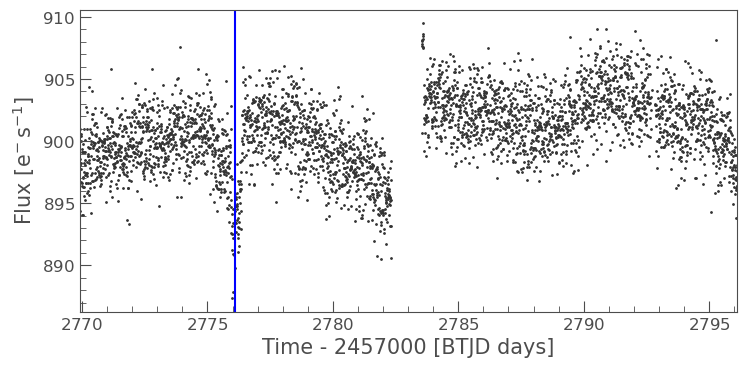

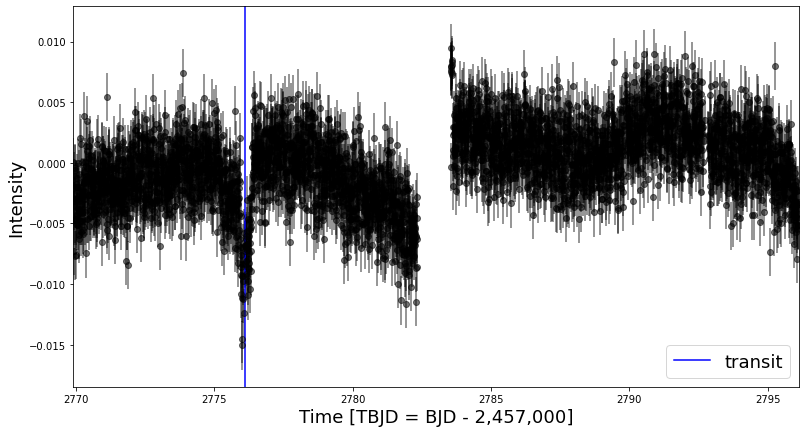

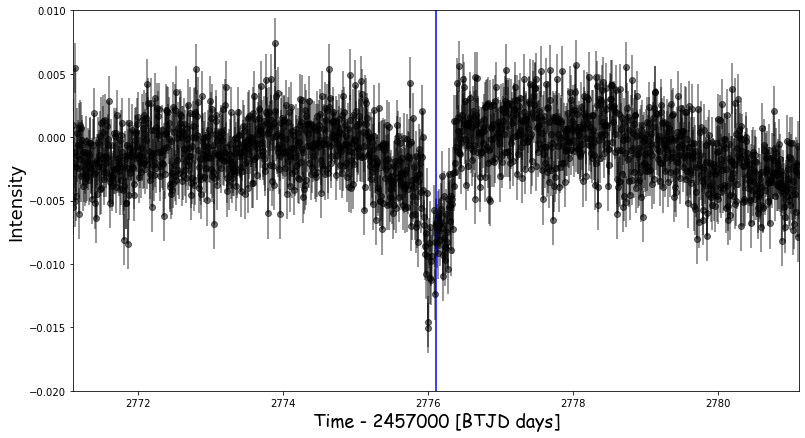

In [12]:
corrected_lc = []
x = []
y = []
yerr = []
for ii in range(0, len(tpf)):
    a_target_lc = target_lc[ii]
    a_background_estimate_lc = background_estimate_lc[ii]
    
    corrected_lc.append(a_target_lc - a_background_estimate_lc.flux)
    
    x.append(corrected_lc[ii].time.value)
    mu = np.median( corrected_lc[ii].flux.value )
    y.append( corrected_lc[ii].flux.value / mu - 1 )
    yerr.append( corrected_lc[ii].flux_err.value[ii] / mu )
    
    
    ax = corrected_lc[ii].scatter();
    
    plt.axvline(2459776.11-2457000, 0, 1, color = 'b', label='Kepler + BARO + BARON linear ephemeris')
    
    
    plt.xlim(np.min(corrected_lc[ii].time.value), np.max(corrected_lc[ii].time.value))
    plt.show()
    
    
    
    
    
    
    
    
    plt.figure(figsize=[13,7])
    plt.errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color = 'k', ls='')
    plt.axvline(2459776.11-2457000, 0, 1, color = 'b', label='transit')
    
    
    plt.xlim(np.min(corrected_lc[ii].time.value), np.max(corrected_lc[ii].time.value))
    plt.xlabel('Time [TBJD = BJD - 2,457,000]', fontsize = 18)
    plt.ylabel('Intensity', fontsize = 18)
    plt.legend(fontsize=18, loc=4)
    
    plt.savefig('koi3678_tess_normalizedLC_smallAperture.pdf')
    plt.show()
    
    
    
    
    
    
    
    
    
    plt.figure(figsize=[13,7])
    plt.errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color = 'k')
    plt.axvline(2459776.11-2457000, 0, 1, color = 'b', label='Kepler + BARO + BARON linear ephemeris')
    
    
    plt.xlim(2459776.11-2457000-5, 2459776.11-2457000+5)
    plt.ylim(-0.02, 0.01)
    plt.xlabel('Time - 2457000 [BTJD days]', fontname='Comic Sans MS', fontsize = 18)
    plt.ylabel('Intensity', fontsize = 18)
    plt.savefig('koi3678_tess_normalizedLC_transit_smallAperture.pdf')

    plt.show()
    
    




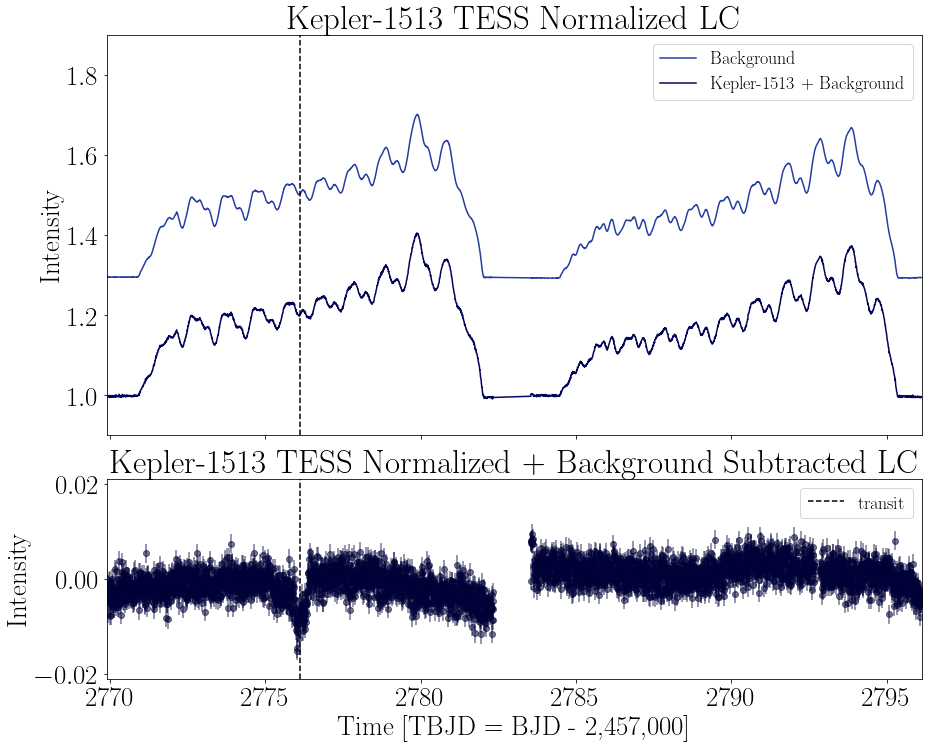

In [13]:
import matplotlib 
matplotlib.rc('xtick', labelsize=27) 
matplotlib.rc('ytick', labelsize=27) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

colors = ["#253DA1",
"#02055A",
"#000137"]

common_normalization = []
for ii in range(0, len(tpf)):
    a_target_lc = target_lc[ii]
    a_background_estimate_lc = background_estimate_lc[ii]
    a_background_lc_per_pixel = background_lc_per_pixel[ii]
    a_n_target_pixels = n_target_pixels[ii]
    
    

    a_common_normalization = np.nanpercentile(a_target_lc.flux, 10)
    common_normalization.append(a_common_normalization)
    
    fig, ax = plt.subplots(2,1,figsize=[13,10.5], sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    ax[0].plot(a_target_lc.time.value, a_background_estimate_lc.flux.value/a_common_normalization.value+1,
              label='Background', color=colors[0])
    ax[0].plot(a_target_lc.time.value, a_target_lc.flux.value/a_common_normalization.value, 
               label='Kepler-1513 + Background', color=colors[1])
    ax[0].axvline(2459776.11-2457000, 0, 1, color='k', ls='--')

    
    
    
    ax[1].errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color=colors[2], ls='')
    ax[1].axvline(2459776.11-2457000, 0, 1, color='k', label='transit', ls='--')
    
    ax[0].set_ylim(0.9, 1.9)
    ax[1].set_ylim(-0.021, 0.021)
    ax[1].set_xlim(np.min(corrected_lc[ii].time.value), np.max(corrected_lc[ii].time.value))
    ax[1].set_xlabel('Time [TBJD = BJD - 2,457,000]', fontsize = 27)
    ax[0].set_ylabel('Intensity', fontsize = 27)
    ax[1].set_ylabel('Intensity', fontsize = 27)
    ax[0].legend(fontsize=18, loc=1)
    ax[1].legend(fontsize=18, loc=1)
    
    
    
    
    ax[0].set_title('Kepler-1513 TESS Normalized LC', fontsize=33)
    ax[1].set_title(r'Kepler-1513 TESS Normalized + Background Subtracted LC', fontsize=33)
    
    plt.tight_layout()
    plt.savefig('koi3678_tess_LC_all_smallAperture.pdf')


(2775.1099999998696, 2777.1099999998696)

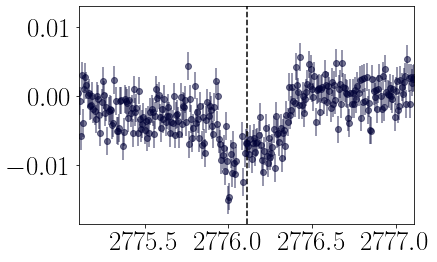

In [16]:

plt.errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color=colors[2], ls='')
plt.axvline(2459776.11-2457000, 0, 1, color='k', label='transit', ls='--')

plt.xlim(2459776.11-2457000-1, 2459776.11-2457000+1)

In [ ]:
2459776.11-2457000

In [ ]:
import pandas as pd

transit_data = {}

transit_data["time [BJD]"] = x[0] + 2457000
transit_data["flux"] = y[0]
transit_data["flux_err"] = yerr[0]
    
    
transit_df = pd.DataFrame(transit_data)

transit_df.to_csv('TESS_koi3678.csv', index=False)


In [ ]:
def determine_cadence(times):
    time_gaps = {}
    for ii in range(1, len(times)):
        time_gap = np.round(times[ii]-times[ii-1], 4)
        if time_gap in time_gaps.keys():
            time_gaps[time_gap] += 1
        else:
            time_gaps[time_gap] = 1
            
    #find the key that corresponds to the most data gaps, this is the cadence
    cadence = max(time_gaps, key=time_gaps.get)
    return cadence
            




def find_nearest(array, value):
    #returns the value in an array closest to another input value
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]



In [ ]:
def tic_id_from_simbad(other_id):
    #takes other_id (string) and queries Simbad to obtain the TIC ID
    
    from astroquery.simbad import Simbad
    import astropy
    ID_table = Simbad.query_objectids(other_id)
    
    if type(ID_table) is not astropy.table.table.Table:
        return(None)
    
    ID_table['ID'] = ID_table['ID'].astype(str)
    

    ID_pandas = ID_table.to_pandas()
    tic_id = ID_pandas[ID_pandas['ID'].str.contains("TIC")]
    
    
    return tic_id['ID'].values[0]


def tic_id_from_exoplanet_archive(other_id):
    # if SIMBAD can't get TIC ID, looks for it in exoplanet archive
    # most of this is from transit_info_from_exoplanet_archive tbh; hesitant to try to merge functions
    
    import pandas as pd


    # SIMBAD should be able to grab data for already confirmed systems
    # this is primarily for TOI candidates
    
    a = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=toipfx,tid,pl_tranmid,pl_orbper,pl_trandurh&format=csv"

    exoplanets = pd.read_csv(a)
    print(exoplanets)

    #rename columns
    column_dict = {
    'toipfx':'toi_host',    
    'tid':'tic_id',
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandurh':'duration [hours]',
    }

    exoplanets.rename(columns=column_dict, inplace=True)
    
    exoplanets['toi_host'] = 'TOI-' + exoplanets['toi_host'].astype(str)
    exoplanets['tic_id'] = 'TIC ' + exoplanets['tic_id'].astype(str)
    
    # replacing any chars that don't match with ones that do; standardizes user input
    
    other_id = other_id.lstrip('toi- TOI')
    other_id = 'TOI-' + other_id # there's probably a smarter way to do this
    


    tic_id = exoplanets['tic_id'].loc[exoplanets['toi_host'] == other_id]



    return tic_id.values[0]



def transit_info_from_exoplanet_archive(tic_id):
    #takes TIC ID and queries exoplanet archive to return t0, period, and duration
    
    import pyvo as vo
    import pandas as pd


    service = vo.dal.TAPService("https://exoplanetarchive.ipac.caltech.edu/TAP")
    
    a = service.search("SELECT \
                       tic_id, pl_tranmid, pl_orbper, pl_trandur\
                       FROM pscomppars")
    
   
    
    exoplanets = a.to_table()
    
    exoplanets = exoplanets.to_pandas()
    
    
    #rename columns
    column_dict = {
    'pl_tranmid':'t0 [BJD]',
    'pl_orbper':'period [days]',
    'pl_trandur':'duration [hours]',
    }
    
    exoplanets.rename(columns=column_dict, inplace=True)
    
    result = exoplanets[exoplanets['tic_id'] == tic_id]

    #if there's no row in the planetary comparison table, check TOI table
    if result.empty:
        print("Exoplanet Archive: TOI Table")
        print("----------------------------")
        a = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=tid,pl_tranmid,pl_orbper,pl_trandurh&format=csv"

        exoplanets = pd.read_csv(a)
        
        #rename columns
        column_dict = {
        'tid':'tic_id',
        'pl_tranmid':'t0 [BJD]',
        'pl_orbper':'period [days]',
        'pl_trandurh':'duration [hours]',
        }
        
        exoplanets.rename(columns=column_dict, inplace=True)
        exoplanets['tic_id'] = 'TIC ' + exoplanets['tic_id'].astype(str)
        
        result = exoplanets[exoplanets['tic_id'] == tic_id]
        
        
    else:
        print("Exoplanet Archive: Planet Comparison Table")
        print("------------------------------------------")
        
    

    return result
    
    




def get_transit_info(object_id):
    #takes a id, queries Simbad to get matching TIC ID
    #then queries exoplanet archive to extract t0, period, and duration
    #if no Simbad match found, then returns None and prints error message
    #if no exoplanet archive match found, then returns None and prints error message

    tic_id = tic_id_from_simbad(object_id)
    
    if tic_id == None:
        # search on exoplanet archive
        print("No TIC ID match found on Simbad")
        print("Checking on exoplanet archive")
        
        tic_id = tic_id_from_exoplanet_archive(object_id)
        
        if tic_id == None:
            print("No TIC ID match found on exoplanet archive either.")
            return None
        
        else:
            print('Found ' + tic_id)
            transit_info = transit_info_from_exoplanet_archive(tic_id)
            
            if transit_info.empty:
                print("No transit info found (???? Archive TIC ID found.)")
                return None
            
            else:
                return transit_info
    
    else: # Simbad does find TIC ID
        transit_info = transit_info_from_exoplanet_archive(tic_id)
        
        if transit_info.empty:
            print("No TIC ID match found on exoplanet archive (???? Simbad TIC ID found.)")
            return None
        
        else:
            return transit_info




            
def get_light_curve(object_id, flux_type, TESS = False, Kepler = False, 
                    user_period = None, user_t0 = None, user_duration = None,
                    planet_number = 1, mask_width = 1.3):
    

    transit_info = get_transit_info(object_id)
    if type(transit_info) == None:
        return None
    
    print('NASA Exoplanet Archive planet parameters:')
    print('planet #,[    tic_id      ,    t0 [BJD]    ,  P [days] , tdur [hrs]')
    transit_info_list = transit_info.astype(str).values.tolist()
    for ii in range(0, len(transit_info_list)):
        print("planet " + str(ii+1) + ", " + str(transit_info_list[ii]))

    
    tic_id = str(transit_info['tic_id'].values[0])
    
    
    if user_period != None:
        periods = np.array(transit_info['period [days]'].values, dtype = float)
        periods[planet_number-1] = user_period

        print("using periods = " + str(periods))

    else:
        periods = np.array(transit_info['period [days]'].values, dtype = float)

        
    if user_t0 != None:
        t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)
        t0s[planet_number-1] = user_t0

        print("using t0s = " + str(t0s))

    else:
        t0s = np.array(transit_info['t0 [BJD]'].values, dtype = float)

    if user_duration != None:
        durations = np.array(transit_info['duration [hours]'].values, dtype = float)
        durations[planet_number-1] = user_duration

        print("using durations = " + str(durations))


        
    else:
        durations = np.array(transit_info['duration [hours]'].values, dtype = float)
    
    
    

    #if no duration values input, just assume a 2 hour duration
    for ii in range(0, len(durations)):
        if np.isnan(durations[ii]):
            print('no duration information on exoplanet archive for the ' + str(ii+1) + 'th planet')
            print('assuming 2 hours for '+ str(ii+1) + 'th planet duration!')
            durations[ii] = 2.
    
    print('')
    print('')


    
    
    

    nplanets = len(periods)
    
    if TESS:
        #switch to TESS BJD
        t0s = t0s - 2457000
        
        if flux_type == 'qlp':
            lc_files = lk.search_lightcurve(
                tic_id, mission='TESS', author = 'qlp'
            ).download_all()
        
        else:
            #pull in short cadence TESS SPOC LC
            lc_files_short_cadence = lk.search_lightcurve(
                tic_id, mission='TESS', author = 'SPOC', cadence = 'short'
            ).download_all(quality_bitmask="hardest", flux_column=flux_type)

            #pull in long cadence TESS SPOC LC
            lc_files_long_cadence = lk.search_lightcurve(
                tic_id, mission='TESS', author = 'SPOC', cadence = 'long'
            ).download_all(quality_bitmask="hardest", flux_column=flux_type)


            #use short cadence TESS data if if exists, else use long cadence
            if lc_files_short_cadence == []:
                lc_files = lc_files_long_cadence
            else:
                lc_files = lc_files_short_cadence
        
    if Kepler:
        #switch to Kepler BJD
        t0s = t0s - 2454833
        
        #pull in Kepler LC
        lc_files = lk.search_lightcurve(
            tic_id, mission='Kepler'
        ).download_all(quality_bitmask="hardest", flux_column=flux_type)
        
    
    quarters = []
    crowding = []
    flux_fraction = []

    try:
        for file in lc_files:
            quarters.append([np.min(file.time.value),
                            np.max(file.time.value)])
            
            if flux_type != 'qlp':
                crowding.append(file.CROWDSAP)
                flux_fraction.append(file.FLFRCSAP)

    except TypeError:
        if TESS:
            mission = 'TESS'
        else:
            mission = 'Kepler'
        error_message =  'no ' + mission + ' ' + flux_type + ' data found for ' + object_id + ', so the code will break...'


        print('')
        print('')
        print('')
        print('')
        print(error_message)
        print('')
        print('')
        print('')
        print('')

        return None
        
        
    
        
    lc = lc_files.stitch().remove_nans()
    
    xs = lc.time.value
    ys = lc.flux
    ys_err = lc.flux_err
    

   

    mask = np.zeros(np.shape(xs), dtype=bool)
    for ii in range(0, nplanets):
        masks = lc.create_transit_mask(period=periods[ii], 
                                       duration=durations[ii]/24.*mask_width, 
                                       transit_time=t0s[ii])
        mask += masks
        
    mask_fitted_planet = lc.create_transit_mask(period=periods[planet_number-1], 
                                                duration=durations[planet_number-1]/24.*mask_width, 
                                                transit_time=t0s[planet_number-1])

    
    
    
    
    
    #save the period, duration, and t0 for the planet we are fitting for...
    period = np.array([periods[planet_number-1]])
    t0 = t0s[planet_number-1]
    duration = np.array([durations[planet_number-1]])


    nan_values = []
    if np.isnan(period[0]):
        nan_values.append('period')
    if np.isnan(t0):
        nan_values.append('t0')
    if np.isnan(duration[0]):
        nan_values.append('duration')



    if nan_values != []:
        print('')
        print('')
        print('')
        print('')
        print(str(nan_values) + ' input is (are) not a number(s), so the code will break...')
        print('')
        print('')
        print('')
        print('')

        return None
    
    
    print('using the following params for the planet we are fitting')
    print("--------------------------------------------------------")
    
    if TESS:
        print('[  t0 [TESS BJD]  , P [days], tdur [hrs]')
    if Kepler:
        print('[ t0 [Kepler BJD] , P [days], tdur [hrs]')
    print('[' + str(t0) + ', ' + str(period[0]) + ', ' + str(duration[0]) + ']')
    
    
    
    min_time = xs.min()
    max_time = xs.max()
    t0s_all = []
    while t0 > min_time:
        t0 -= period[0]

    while t0 < max_time:
        t0s_all.append(t0)
        t0 += period[0]
    
    

    cadence = determine_cadence(xs)

    t0s_in_data = []
    for t0 in t0s_all:
        nearest_lc_time = find_nearest(xs, t0)
        
        # if there is a data point within the cadence (times some uncertainty lets say 3) of 
        # expected transit then there should be transit data
        if np.abs(t0 - nearest_lc_time) < 3*cadence: 
            t0s_in_data.append(t0)


    print(t0s_in_data)
            
    
    print('')
    print(str(len(t0s_in_data)) + ' transits (or epochs) in total')      
    print('')


    mu = np.median( ys )
    ys = ( ys / mu - 1 )
    ys_err = ( ys_err / mu )
    
    

    
    

    
    return \
        np.array(xs), np.array(ys), np.array(ys_err), mask, mask_fitted_planet, \
        np.array(t0s_in_data), period, duration, quarters, crowding, flux_fraction

In [ ]:
lc = get_light_curve('koi-3678', 'qlp', TESS = True)

In [ ]:
valid_epochs = []
for epoch in epochs:
    if epoch > lc[0].min() + 2457000 - 2454833 and epoch < lc[0].max() + 2457000 - 2454833:
        print(epoch)
        valid_epochs.append(epoch)

In [ ]:
import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 


plt.figure(figsize=[18,9])
plt.plot(lc[0] + 2457000 - 2454833, lc[1], 'o', color='k')
for t0 in lc[5]:
    plt.axvline(t0, 0, 1, color='r')

    
    
    
plt.xlabel('time [KBJD]', fontsize=27)
plt.ylabel('intensity', fontsize=27)
for epoch in valid_epochs:
    plt.axvline(epoch, 0, 1, color='b', label = 'transits')
plt.title('KOI-3678 Kepler QLP data', fontsize = 36)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=27)

plt.tight_layout()


plt.savefig('koi3678_QLP_data.pdf')

In [ ]:
lk.search_lightcurve('koi-3678', mission='TESS')